In [1]:
from __future__ import print_function
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras.layers import Layer
import jlr_util
import numpy as np
from keras import backend as K
np.set_printoptions(precision=2)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [155]:
def load_data(infile):
    #load the input data
    inf = open(infile, "rb")
    data = np.load(inf)
    Xreco = data["X_reco"]
    return Xreco

In [73]:
Xreco, Xmatch, Xparton_cart, y = jlr_util.load_data("./data/processed/data_fh.npz")
mean = np.mean(y)
std = np.std(y)
y = (y-mean)/std

In [96]:
Xbkg = load_data("./data/processed/data_ttjets_fh.npz")

In [156]:
ntrain = 3000000
X_train = Xreco[:ntrain]
y_train = y[:ntrain]

X_test = Xreco[ntrain:]
y_test = y[ntrain:]

In [157]:
mod = jlr_util.build_densenet(X_train, 3, 0.2, 256, True, "relu", 0.0)

In [158]:
opt = keras.optimizers.Adam(lr=0.001, clipnorm=1.0)
mod.compile(loss=jlr_util.neg_r2_score, optimizer=opt, metrics=[jlr_util.r2_score])

In [159]:
mod.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=1000)

Train on 3000000 samples, validate on 839052 samples
Epoch 1/50
3000000/3000000 [==============================] - 115s 38us/step - loss: -0.0532 - r2_score: 0.0532 - val_loss: -0.0928 - val_r2_score: 0.0928
Epoch 2/50
3000000/3000000 [==============================] - 122s 41us/step - loss: -0.0927 - r2_score: 0.0927 - val_loss: -0.1051 - val_r2_score: 0.1051
Epoch 3/50
3000000/3000000 [==============================] - 90s 30us/step - loss: -0.1008 - r2_score: 0.1008 - val_loss: -0.1084 - val_r2_score: 0.1084
Epoch 4/50
3000000/3000000 [==============================] - 85s 28us/step - loss: -0.1049 - r2_score: 0.1049 - val_loss: -0.1124 - val_r2_score: 0.1124
Epoch 5/50
3000000/3000000 [==============================] - 86s 29us/step - loss: -0.1073 - r2_score: 0.1073 - val_loss: -0.1112 - val_r2_score: 0.1112
Epoch 6/50
3000000/3000000 [==============================] - 86s 29us/step - loss: -0.1093 - r2_score: 0.1093 - val_loss: -0.1148 - val_r2_score: 0.1148
Epoch 7/50
3000000/30

KeyboardInterrupt: 

In [160]:
ysig_pred_train = mod.predict(X_train, batch_size=100000)
ysig_pred_test = mod.predict(X_test, batch_size=100000)

In [161]:
ybkg_pred = mod.predict(Xbkg[:50000], batch_size=10000)

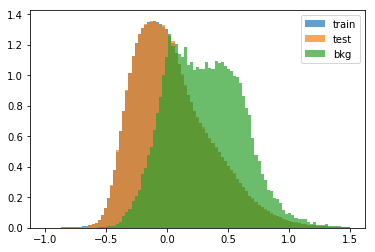

In [162]:
plt.hist(ysig_pred_train[:, 0], bins=np.linspace(-1, 1.5, 100), density=1.0, alpha=0.7, label="train");
plt.hist(ysig_pred_test[:, 0], bins=np.linspace(-1, 1.5, 100), density=1.0, alpha=0.7, label="test");

plt.hist(ybkg_pred[:, 0], bins=np.linspace(-1, 1.5, 100), density=1.0, alpha=0.7, label="bkg");
plt.legend()

In [163]:
import sklearn
import sklearn.metrics

In [164]:
def roc_curve_vecs(vs, vb, bins):
    hs, _ = np.histogram(vs, bins)
    hb, _ = np.histogram(vb, bins)
    
    chs = np.cumsum(hs)/float(np.sum(hs))
    chb = np.cumsum(hb)/float(np.sum(hb))

    plt.plot(chs, chb)

(0, 1)

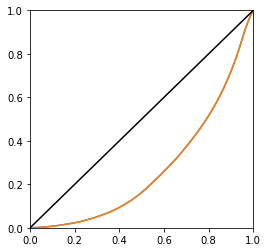

In [165]:
plt.figure(figsize=(4,4))
roc_curve_vecs(ysig_pred_test[:, 0], ybkg_pred[:, 0], np.linspace(-1,1.5,100))
roc_curve_vecs(ysig_pred_train[:, 0], ybkg_pred[:, 0], np.linspace(-1,1.5,100))
plt.plot([0,1],[0,1], color="black")
plt.xlim(0,1)
plt.ylim(0,1)